In this first part, I'll be trying to understand the design and implementation behind the pytorch nn.Module and how it ties in with fastai. In this section, I will be exploring basic neural net ops and how the pytorch modelling works. The dataset I am using is the KMNIST dataset which can be found [here](https://github.com/rois-codh/kmnist)

First, some imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor, from_numpy, flatten
import operator
from functools import partial

import pandas as pd

We'll be starting with only the basics here (so no fancy packages). However, to work with kmnist more easily also import numpy

In [2]:
import numpy as np

In [4]:
DATA_DIR = Path("/Users/wwymak/computer-science-courses/kmnist")

In [5]:
X_train = np.load(DATA_DIR / "kmnist-train-imgs.npz")['arr_0'].astype('float')
X_test = np.load( DATA_DIR / "kmnist-test-imgs.npz")['arr_0'].astype('float')
y_train = np.load(DATA_DIR / "kmnist-train-labels.npz")['arr_0'].astype('float')
y_test = np.load(DATA_DIR / "kmnist-test-labels.npz")['arr_0'].astype('float')

We can also see the mapping between the class labels (0-9) and the actual characters

In [8]:
char_mapping =pd.read_csv("/Users/wwymak/computer-science-courses/kmnist/kmnist_classmap.csv")
char_mapping

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


KMNIST is in uint8 rather than float, with data in range 0 - 255:

In [7]:
X_train.min(), X_train.max()

(0.0, 255.0)

Since we want to work with (mostly) pytorch, convert the inputs to pytorch tensors using the python native `map` function which does `map(func, iterable)` -> applies the `func` to all elements in iterable. Also to ensure that we get float tensors, we call `.float()` on the result pytorch tensors

In [9]:
X_train, X_test, y_train, y_test = map(from_numpy, (X_train, X_test, y_train, y_test) )
X_train, X_test, y_train, y_test= [x.float() for x in (X_train, X_test, y_train, y_test )]

KMNIST is in the shape `[num_samples, 28, 28]` so convert to `[num_samples, 28*28]` to work with the following examples

In [11]:
X_train = X_train.reshape([X_train.shape[0],-1])
X_test = X_test.reshape([X_test.shape[0],-1])

Let's grab a few characters to see what they look like before procedding further:

In [18]:
def pytorch_rand_int(low, high):
    """
    generate a random int between min and max using pytorch native funcs
    """
    return torch.randint(low, high, size=(1,)).numpy()[0]

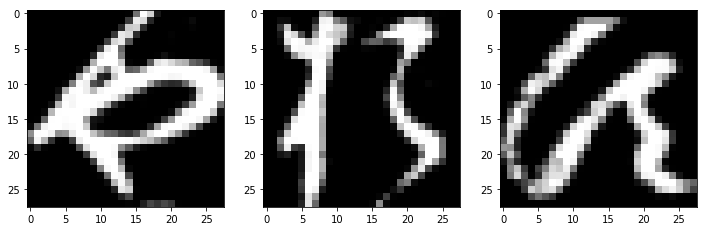

In [21]:
plt.figure(figsize=(12,4))
for i in range(1, 4):
    ax = plt.subplot(1, 3, i)
    random_sample = pytorch_rand_int(0, X_train.size()[0])
    ax.imshow(X_train[random_sample].view(28, 28), cmap='gray')


Next, we also want to normalise the data so e.g. illumniation does affect the output of the training/prediction. In normalistaion we rescale the samples so they have mean 0 and standard deviation of 1

In [22]:
def normalise(x, mean, std):
    return (x - mean) /std

In [23]:
train_mean = X_train.mean()
train_std = X_train.std()
train_mean, train_std

(tensor(48.9312), tensor(88.8274))

Now let's normalise our train/test tensors. Note, we have to use the _train_ mean/std for the test set otherwise the network might be predicting on data that looks very different to the training set if e.g. the test set all have a much higher intensity

In [24]:
X_train = normalise(X_train, train_mean, train_std)
X_test = normalise(X_test, train_mean, train_std)

Now if we recalculate the mean/std we should see them to be approx mean = 0, std = 1

In [25]:
train_mean = X_train.mean()
train_std = X_train.std()
train_mean, train_std

(tensor(-0.0003), tensor(1.))

we can define a test for whether the number is more or less what we expect (due to computation, its usually never exactly 0.000 to an infinite amount of zeros...

In [26]:
def test_near_zero(a, tolerance = 1e-3):
    assert a.abs() < tolerance, f"{a} not near zero"

In [27]:
test_near_zero(train_mean)
test_near_zero(1 - train_std)

Let's check the dimensions of our tensors -- these should be `X_train = [60000, 784]` (we have 60k training samples) and `nclasses = 10`

In [28]:
n, m = X_train.shape
nclasses = y_train.max() + 1

n, m, nclasses

(60000, 784, tensor(10.))

### basic neural net

let's define a simple fully connected neural net with 1 hidden layer.  as per neural net definition, each layer is just a matrix multiplication of `W . x + b` for weight matrix `W` and bias `b`. In this most basic version, we will use MSE as the metric (ie the network acts as a regressor rather than the 'normal' classification.

In the neural net training, we would ideally keep the mean/std of the result of each layer to be 0/1. This is to help the net train-- if the mean/std keeps on decreasing over the layers we get a vanishing gradient on backpropagation and if it keeps incresasing then we get to infinity very quickly...

In [29]:
# number of neurons in the hidden layer:
nh = 50

by the rules of matrix multiplication, to get to nh hidden layers  W1 will have to be of shape (m, nh), and b1 shape nh, W2 have shape (nh, 1), b2 shape(1)

Let's init the weight and biases. W1, W2, b1, and b2 are learned params, so they can be random -- b1 and b2 are zero since they are just additive const, but W1 and W2 can't be zero-- if they are, the whole network collapses, so init them with random weights.

In [31]:
# the sqrt(m) is the normalisation const for simplified version of kaiming init
W1 = torch.randn(m, nh) / math.sqrt(m)
W2 = torch.randn(nh, 1)/  math.sqrt(m)

b1 = torch.zeros(nh)
b2 = torch.zeros(1)

now, let's check that we still get the desired mean = 0, std = 1 behavior with these random weights:

In [32]:
# sanity check that our train has mean and std of 0, 1
X_train.mean(), X_train.std()

(tensor(-0.0003), tensor(1.))

An operation through 1 layer neural net can be thought of as:

In [33]:
def lin(X, w, b): 
    """
    X, w are tensors, b the bias vector. X@w is the matmul
    """
    return X@w + b

If we run X_test through the above layer, we get:

In [34]:
t = lin(X_test.float(), W1.float(), b1.float())
t.mean(), t.std()

(tensor(-0.0274), tensor(1.0044))

To get the non linearity in the neral net, there is usually an activation function. One of the most common types of activation in neural nets is the relu:

In [35]:
def relu(x):
    return x.clamp_min(0.)

In [100]:
# apply reul to t:
t = relu(t)
t.mean(), t.std()

(tensor(0.4020), tensor(0.5866))

The mean and std are no longer near 0/ 1. This is because of the relu, in which we lost half of the input (anything -ve is zero). So the 'proper' init for relu is to take away a 0.5. As we can see, we're back in action with mean approx zero and std closer to 1


In [37]:
def general_relu(x, offset=-0.5):
    return x.clamp_min(0.) - 0.5

W1 = torch.randn(m,nh)*math.sqrt(2/m)
t = general_relu(lin(X_test.float(), W1.float(), b1.float()))
t.mean(), t.std()

(tensor(0.0178), tensor(0.7813))

The Kaiming init method is implemented in Pytorch as [`torch.nn.init.kaiming_normal_`](https://github.com/pytorch/pytorch/blob/8868a4f20be52704df23d96bda8f600d349a6b9f/torch/nn/init.py#L295) / [`torch.nn.init.kaiming_uniform_`](https://github.com/pytorch/pytorch/blob/8868a4f20be52704df23d96bda8f600d349a6b9f/torch/nn/init.py#L260) 

In [38]:
from torch.nn import init

In [39]:
W1 = torch.randn(m,nh)
init.kaiming_normal_(W1, mode='fan_out')
t = general_relu(lin(X_test.float(), W1.float(), b1.float()))
t.mean(), t.std()

(tensor(0.0646), tensor(0.8102))

### Layers as classes

Pytorch is fairly strongly OOP and we can define each layer as a class that we can resue. Each layer should have a forward pass method to calculate the loss and a backward pass for backpropagation.

To make sense of the backward pass gradient calculations, we have to remember the chain rule in differentiation. 

e.g if the network has 3 layers, with `h -> g -> f`, the input `x` is transformed by `L = f(g(h(x)))`. 

So in backprop: `dL/dx = df/dg * dg/dh * dh/dx`. Thinking in terms of layers, if we take the middle layer as an example, the total gradient after backprop through that layer is `df/dg (out.grad)` multiplied by the `dg/dh` (current grad)

A much more detailed explanation of backpropagation can be found from [cs231n](http://cs231n.github.io/optimization-2/)

#### Vectorized grads intuitions

In [47]:
W1 = torch.tensor([[1., 2., 3.], [4., 5., 6.]])
x = torch.tensor([[1., 2.], [4., 5.]])
b = torch.tensor([[1.], [1.]])

Let's print out the shapes of these tensors

In [49]:
x@W1

tensor([[ 9., 12., 15.],
        [24., 33., 42.]])

In [50]:
x@W1 + b

tensor([[10., 13., 16.],
        [25., 34., 43.]])

In [53]:
x.size()

torch.Size([2, 2])

In [54]:
W1.size()

torch.Size([2, 3])

In [52]:
(x@W1).size()

torch.Size([2, 3])

In a non tensor eq: `y = Wx + b`, `dy/dx = W`. However, if W and x are tensors it's a bit of a different story, and you have to be careful about the transpose. In the above example, the input has shape(2,2), and the output shape(2,3). the input gradient should have the same shape as the input, (2,2), and the grad of the output shape (2,3) 
which means  for `out_grad@W1` to work, W1 has to have shape(3,2), ie transpose of W1

#### Layer defs
We can define each common layer e.g. Relu/Linear as a class. By overriding the python `__call__` dunder method we can use a class like a function def e.g. `Relu(x)`. In each of the classes, we would like to do the backward propagation, which would update the input_grad with `grad_of_layer * grad_output_tensor`

In [42]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self):
#         relu has grad = 1 for x > 0 and 0 otherwise
        self.inp.g = ( self.inp >0).float() * self.out.g 
    
class Linear():
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
        
    def backward(self):
        self.inp.g = self.out.g@self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)
        
class MSE():
    def __call__(self, inp, target):
        self.inp = inp
        self.target = target
        #mean squared error
        self.out = (inp.squeeze() - self.target).pow(2).mean()
        return self.out
    
    def backward(self):
        # grad = 2 / n * (inp - target)
        self.inp.g = 2. / self.target.shape[0] * (self.inp.squeeze() - self.target).unsqueeze(-1)
                

Finally, we can define our model:

In [55]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Linear(w1, b1), Relu(), Linear(w2, b2)]
        self.loss = MSE()
    
    def __call__(self, x, target):
        for l in self.layers:
            x = l(x)
        return self.loss(x, target)
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [56]:
# define grad property for all the tensors
W1.g, b1.g, W2.g, b2.g = [None] * 4
model = Model(W1, b1, W2, b2)

In [134]:
%time loss = model(X_train, y_train)

CPU times: user 245 ms, sys: 10.3 ms, total: 255 ms
Wall time: 96.8 ms


In [135]:
loss

tensor(28.5553)

In [136]:
%time model.backward()

CPU times: user 10.2 s, sys: 26.8 s, total: 37 s
Wall time: 51.7 s


In [139]:
W1.g

tensor([[-0.0249,  0.0350,  0.0115,  ..., -0.0283,  0.1063, -0.0074],
        [-0.0247,  0.0347,  0.0114,  ..., -0.0281,  0.1049, -0.0073],
        [-0.0244,  0.0343,  0.0112,  ..., -0.0277,  0.1029, -0.0072],
        ...,
        [-0.0242,  0.0318,  0.0105,  ..., -0.0262,  0.0967, -0.0066],
        [-0.0246,  0.0337,  0.0109,  ..., -0.0271,  0.1007, -0.0071],
        [-0.0250,  0.0349,  0.0113,  ..., -0.0281,  0.1049, -0.0073]])

Since each layer has the forward and backward methods, we can define a Module class with the forward and backward methods and have the layers inherit from it. 

In pytorch, this is the `nn.Module` class, which all layers etc in pytorch inherit. The linear, relu layers we defined above are also in pytorch (not the generalised relu though)

In nn.Module, the forward method is not defined by default, but our model does not need to define it if we're not using it, e.g. in the following the forward is done by the layers not the model so we don't need to implement the `forward` in the `Model`

In [57]:
from torch import nn

In [147]:
nn.Module??

In [67]:
# model redefined to inherit from nn.Module
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = nn.MSELoss()
    def __call__(self, x, target):
        for l in self.layers:
            x = l(x)
        return self.loss(x.squeeze(), target)

In [59]:
model = Model(m, nh, 1)

In [179]:
%time loss = model(X_train, y_train)

CPU times: user 215 ms, sys: 12.6 ms, total: 228 ms
Wall time: 130 ms


In [180]:
#  in pytorch the backward is called from the loss which dloss/dx for every parameter x which has requires_grad=True
%time loss.backward()

CPU times: user 184 ms, sys: 8.47 ms, total: 192 ms
Wall time: 86.1 ms
